# Reproducing Schneider et al 2017 - Parameter estimation in a perfect model setting with an Ensemble Kalman Filter

In this notebook, we will combine the L96 model with the EnKF to estimate parameters. We will start, however, with state estimation. This might come in handy layer and is a good learning experience in any case.

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from L96 import *
from EnKF import *
import seaborn as sns
import matplotlib as mpl
sns.set_style('dark')
sns.set_context('talk')
mpl.rcParams['figure.figsize'] = (15,7)

## The Ensemble Kalman Filter

I will largely follow the notation used in Yvonne's thesis:

- $\mathbf{x}$: Model state. In the NWP case $\mathbf{x} = \begin{pmatrix} X \\ Y \end{pmatrix}$, or just $X$ in the one leve case. In the parameter estimation case, add the parameters $\mathbf{x} = \begin{pmatrix} X \\ Y \\ \theta\end{pmatrix}$
- $\mathbf{y}$: Observations. In the fully observable NWP setup these are the state variables. In the climate setup, these are observed/true long-term statistics.
- $h(\mathbf{x})$:  The observation operator that maps the model state to the observable. In case of the fully observable NWP setup, this is simple the state (without the parameters). In the climate setup, these are the model statistics computed from the model integration.


The EnKF algorithm goes as follows

**INSERT YVONNE'S ALGORITHM**

## State estimation with the one layer model

In [3]:
# Create initial conditions
l96 = L96OneLevel(dt=0.01)
l96.iterate(100)
init = l96.X.copy()

In [4]:
enkf = EnKF(
    l96=L96OneLevel(noprog=True), 
    nens=100, 
    obs_noise=1, 
    cyc_len=0.2, 
    mp=10
)

In [5]:
enkf.initialize(init, 1)

In [6]:
enkf.iterate(10)

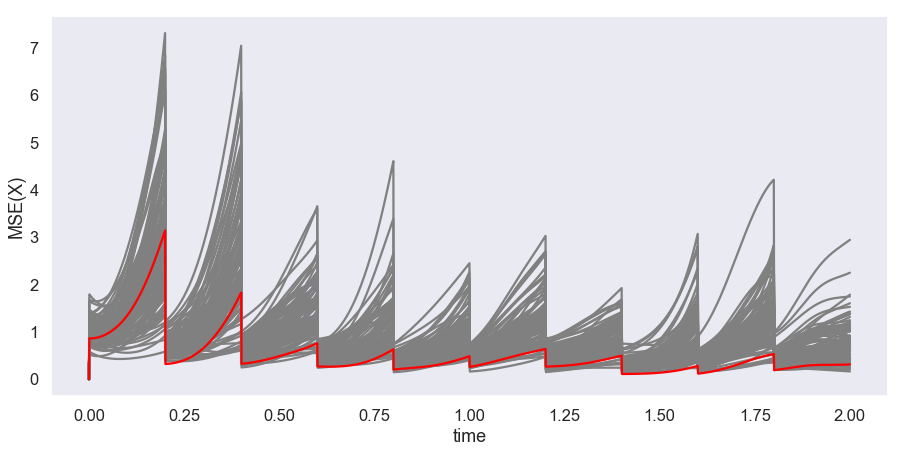

In [9]:
plot_mse(enkf)

## State estimation in the two layer model, only X is observed

In [3]:
# Create initial conditions
l96 = L96TwoLevel()
l96.iterate(100)
init = l96.state

In [4]:
l96.history

<xarray.Dataset>
Dimensions:   (time: 1001, x: 36, y: 360)
Coordinates:
  * time      (time) float64 0.0 0.1 0.2 0.3 0.4 ... 99.6 99.7 99.8 99.9 100.0
  * x         (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 26 27 28 29 30 31 32 33 34 35
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
Data variables:
    X         (time, x) float64 0.6211 0.4279 0.5255 ... 0.4456 -3.415 4.973
    B         (time, x) float64 -0.0 -0.0 -0.0 -0.0 ... 0.0903 0.7928 -2.229
    Y_mean    (time, x) float64 0.0 0.0 0.0 0.0 ... -0.00903 -0.07928 0.2229
    Y2_mean   (time, x) float64 0.0 0.0 0.0 0.0 ... 0.006165 0.03606 0.107
    X_repeat  (time, y) float64 0.6211 0.6211 0.6211 ... 4.973 4.973 4.973
    Y         (time, y) float64 0.0 0.0 0.0 0.0 ... 0.235 -0.2816 0.5035 0.2664

In [5]:
def H(l):
    return l.X

In [33]:
enkf = EnKF(
    l96=L96TwoLevel(noprog=True, save_dt=0.01), 
    nens=100, 
    obs_noise=1, 
    cyc_len=1, 
    mp=10,
    H=H
)

In [35]:
enkf.initialize(init, np.array([1]*36 + [0.1]*360))

In [36]:
enkf.iterate(5)

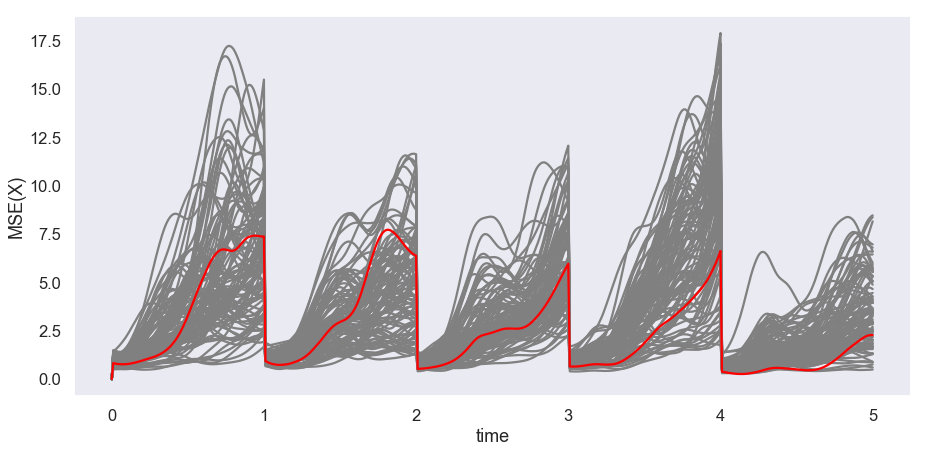

In [37]:
plot_mse(enkf)

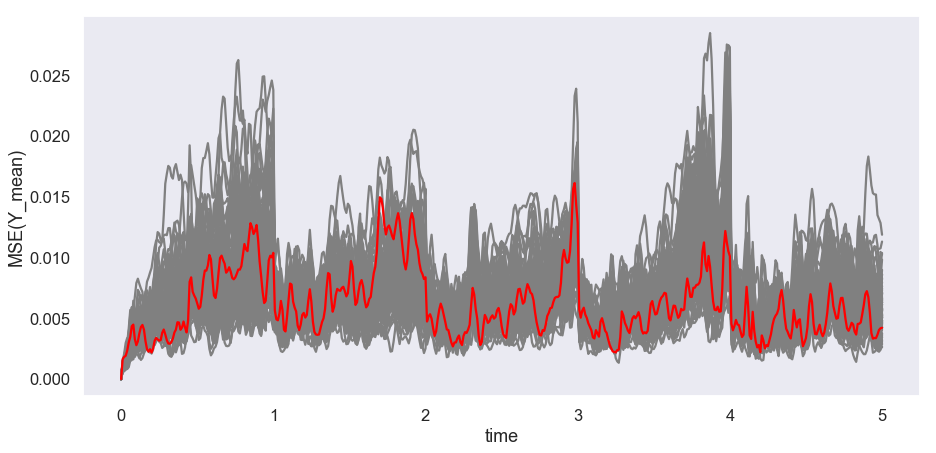

In [38]:
plot_mse(enkf, 'Y_mean')

## Joint state and parameter estimation in the one level model

In [3]:
# Create initial conditions
l96 = L96OneLevel(dt=0.01)
l96.iterate(100)
init = l96.X.copy()

In [5]:
def set_state(l, x_a):
    l.set_state(x_a[:-1])
    l.F = x_a[-1]

In [14]:
enkf = EnKF(
    l96=L96OneLevel(noprog=True), 
    nens=100, 
    obs_noise=1, 
    cyc_len=0.2, 
    mp=10, 
    get_state=lambda l: np.concatenate([l.state, np.atleast_1d(l.F)]),
    set_state=set_state
)

In [15]:
enkf.initialize(init, 1)

In [16]:
def init_F(l, prior, sigma):
    l.F = prior +  + np.random.normal(0, np.sqrt(sigma))

In [17]:
enkf.initialize_parameters(init_F, 15, 10)

In [19]:
enkf.iterate(5)

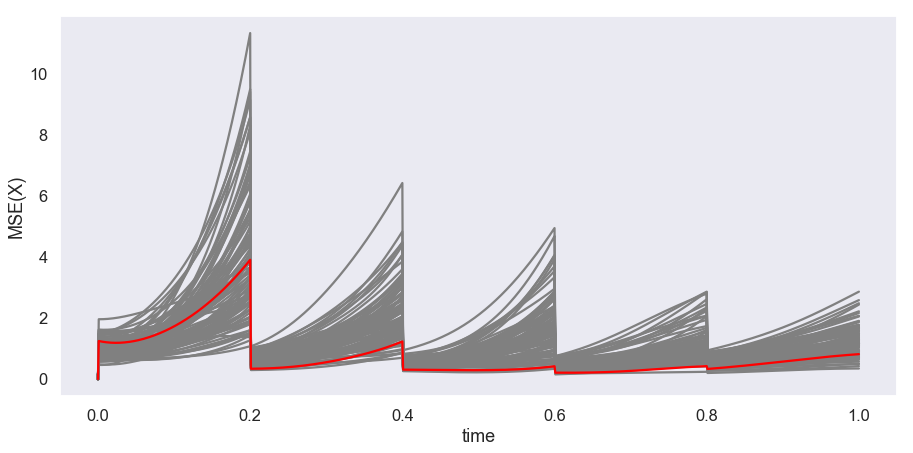

In [28]:
plot_mse(enkf)

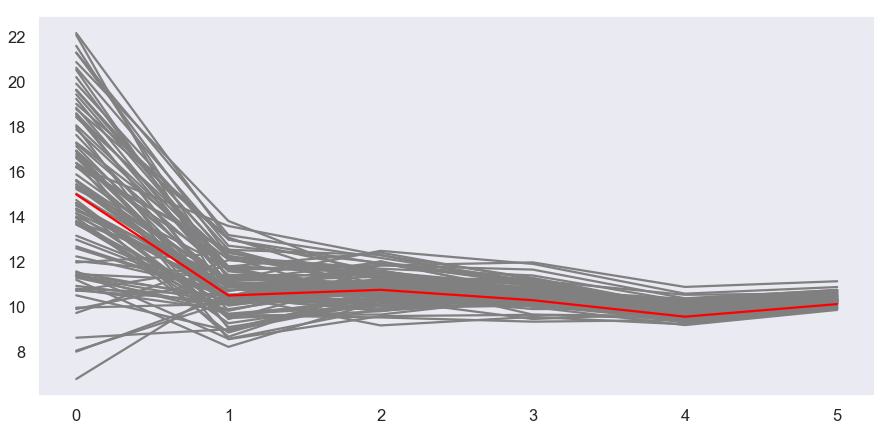

In [29]:
for i in range(100):
    plt.plot(np.array(enkf.parameter_history_ens)[:, i], c='gray')
plt.plot(np.array(enkf.parameter_history_det)[:], c='r')

## Joint state and parameter estimation in the two level model

In [30]:
# Create initial conditions
l96 = L96TwoLevel()
l96.iterate(100)
init = l96.state

In [57]:
def set_state(l, x_a):
    l.set_state(x_a[:-4])
    l.F = x_a[-4]
    l.h = x_a[-3]
    l.c = x_a[-2]
    l.b = x_a[-1]

In [58]:
enkf = EnKF(
    l96=L96TwoLevel(noprog=True, save_dt=0.01), 
    nens=100, 
    obs_noise=1, 
    cyc_len=0.2, 
    mp=10, 
    get_state=lambda l: np.concatenate([l.state, l.parameters]),
    set_state=set_state
)

In [59]:
enkf.initialize(init, 1)

In [60]:
def init_Fhcb(l, prior, sigma):
    l.F = prior[0] + np.random.normal(0, np.sqrt(sigma[0]))
    l.h = prior[1] + np.random.normal(0, np.sqrt(sigma[1]))
    l.c = np.exp(prior[2] + np.random.normal(0, np.sqrt(sigma[2])))
    l.b = prior[3] + np.random.normal(0, np.sqrt(sigma[3]))

In [61]:
enkf.initialize_parameters(init_Fhcb, priors=(10, 0, 2, 5), sigmas=(10, 1, 0.1, 10))

In [69]:
enkf.iterate(5)

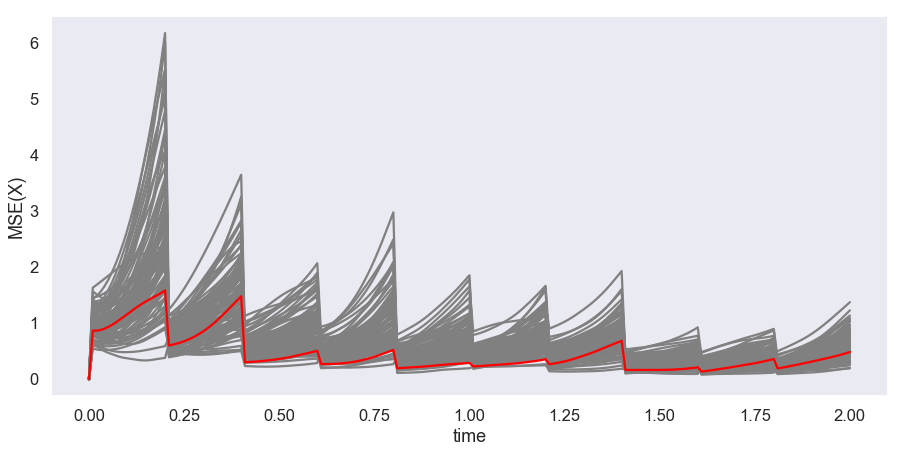

In [72]:
plot_mse(enkf)

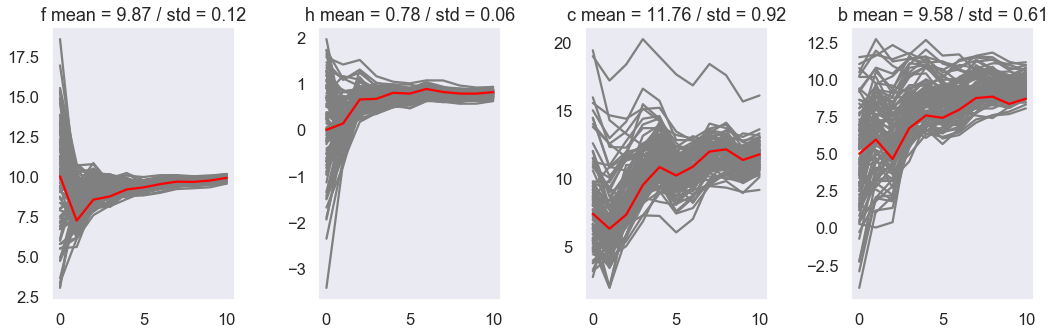

In [84]:
plot_params(enkf)

## Parameter estimation in a climate setup for the one level model

In [14]:
# Create initial conditions
l96 = L96OneLevel(dt=0.01)
l96.iterate(1000)
init = l96.X.copy()

In [16]:
y = l96.mean_stats(0)

In [67]:
obs_variance = l96.mean_stats(0, np.var)
r=0.5

In [78]:
def set_state(l, x_a):
    l.F = x_a

In [79]:
def H(l):
    return np.concatenate([
        np.array(l._history_X).mean(0),
        (np.array(l._history_X)**2).mean(0)
    ])

In [80]:
enkf = EnKF(
    l96=L96OneLevel(noprog=True), 
    nens=100, 
    obs_noise=r**2 * obs_variance, 
    cyc_len=5, 
    mp=10, 
    get_state=lambda l: l.parameters,
    set_state=set_state,
    H=H,
    y=y,
    climate=True
)

In [115]:
enkf.initialize(init, 1)

In [82]:
def init_F(l, prior, sigma):
    l.F = prior +  + np.random.normal(0, np.sqrt(sigma))

In [83]:
enkf.initialize_parameters(init_F, 15, 10)

In [84]:
enkf.iterate(3)

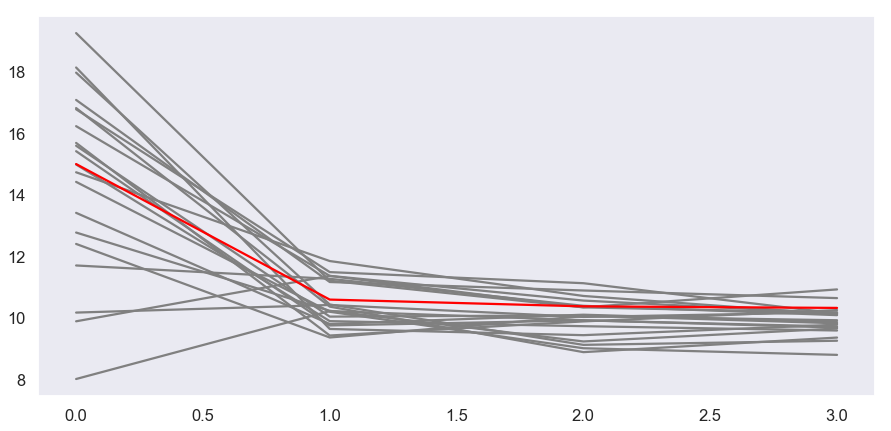

In [85]:
for i in range(20):
    plt.plot(np.array(enkf.parameter_history_ens)[:, i], c='gray')
plt.plot(np.array(enkf.parameter_history_det)[:], c='r')

In [86]:
enkf.climate_error

[0.8270635750143299, 0.46294559320934103, 0.4326033556547098]

## Parameter estimation in the climate setup with the two level model = Schneider et al 2017

In [87]:
# Create initial conditions
l96 = L96TwoLevel()
l96.iterate(100)
init = l96.state

In [90]:
means = np.load('./L96TwoLevel_means.npy')

In [91]:
variances = np.load('./L96TwoLevel_variances.npy')

In [102]:
def set_state(l, x_a):
    l.F = x_a[-4]
    l.h = x_a[-3]
    l.c = x_a[-2]
    l.b = x_a[-1]

In [103]:
def init_Fhcb(l, prior, sigma):
    l.F = prior[0] + np.random.normal(0, np.sqrt(sigma[0]))
    l.h = prior[1] + np.random.normal(0, np.sqrt(sigma[1]))
    l.c = np.exp(prior[2] + np.random.normal(0, np.sqrt(sigma[2])))
    l.b = prior[3] + np.random.normal(0, np.sqrt(sigma[3]))

In [104]:
def H(l):
    return l.mean_stats(0)

In [128]:
enkf = EnKF(
    l96=L96TwoLevel(noprog=True, save_dt=0.001), 
    nens=100, 
    obs_noise=r**2 * variances, 
    cyc_len=100, 
    mp=10, 
    get_state=lambda l: l.parameters,
    set_state=set_state,
    H=H,
    y=means,
    climate=True
)

In [129]:
enkf.initialize(init, np.array([1]*36 + [0.1]*360))

In [130]:
enkf.initialize_parameters(init_Fhcb, priors=(10, 0, 2, 5), sigmas=(10, 1, 0.1, 10))

In [ ]:
enkf.iterate(15)

In [ ]:
plot_params(enkf)